# Classifying CIFAR-10 using a single fully connected layer 
In this notebook, we will see how to learn a classifier with a single linear layer by minimising the cross-entropy loss. The training set for CIFAR-10 contatins 50,000 3x32x32 images, each image belonging to one of the 10 classes. We will also see how to use L2 reqularization and train the classifier using vanila gradient descent.

### 1. Data Loading: Let us load the training and the test data and check the size of the tensors. Let us also display the first few images from the training set.

In [1]:
-- load trainin images
tr_x = torch.load('cifar10/tr_data.bin')
-- load trainin labels 
tr_y = torch.load('cifar10/tr_labels.bin'):double() + 1
-- load test images
te_x = torch.load('cifar10/te_data.bin')
-- load test labels 
te_y = torch.load('cifar10/te_labels.bin'):double() + 1
print(tr_x:size())
print(tr_y:size())

 50000
     3
    32
    32
[torch.LongStorage of size 4]

 50000
[torch.LongStorage of size 1]



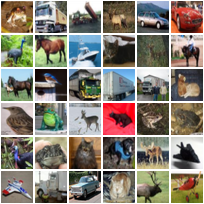

In [2]:
-- display the first 36 training set images
require 'image';
itorch.image(tr_x[{{1,36},{},{},{}}])

### 2. Data Preprocessing: We compute the mean and standard deviation 'images' and then subtract and divide by the same respectively (like VGG).  We also visualize them.

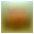

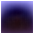

In [3]:
x_mean = torch.mean(tr_x:float(), 1)
x_std = torch.std(tr_x:float(), 1)
itorch.image(x_mean)
itorch.image(x_std)

### 3. Define the linear layer class. We implement the forward and the backward functions. Note that thus class never updates its own weights, it simply computes the gradients for weights.

In [4]:
local Linear = torch.class("Linear")

function Linear:__init(weight_init_range)
    self.output = nil
    self.gradInput = torch.zeros(10):float()
    self.W = 2*(torch.rand(10, 3*32*32):float()-0.5) * weight_init_range
    self.b = 2*(torch.rand(10)-0.5):float() * weight_init_range
    self.gradW = torch.zeros(10, 3*32*32):float()
    self.gradb = torch.zeros(10):float()
end

-- Wx + b
function Linear:forward(xi)
    self.output = self.W * xi + self.b
    return self.output
end

-- dL/dW = dL/do * do/dW (note that we also account for L2 weight reqularization)
function Linear:backward(xi, dl_do)
    self.gradW:copy((xi:reshape(3*32*32,1) * dl_do:reshape(1,10)):t() - lambda * self.W)
    self.gradb:copy(dl_do)
end

-- helper function to remember best model
function Linear:copy(model)
    self.W:copy(model.W)
    self.b:copy(model.b)
end

### 3. Define the Cross Entropy Error class. We implement the forward and the backward functions. The forward function computes the loss and the backward function computes the gradient of the loss with respect to output.

In [5]:
local CEC = torch.class("CEC")

function CEC:__init()
    self.output = nil
    self.gradInput = torch.zeros(10):float()
end

-- L_i = -log(e^yi/sum_j(e^yj)) + lambda*||W||^2
function CEC:forward(op, ti, model, lambda)
    op = op:exp()
    op = op/(op:sum())
    local lossL2 = model.W:clone()
    lossL2 = lossL2:cmul(lossL2):sum()
    self.output = -math.log(op[ti]) + lambda * lossL2
    return self.output
end

-- dL_i/do = 1 - op
function CEC:backward(op, ti)
    self.gradInput:fill(0)
    self.gradInput[ti] = 1
    self.gradInput = self.gradInput - op
    return self.gradInput
end

### 4. Define the vanilla gradient descent function.

In [6]:
function gradient_descent(model, lr)
    model.W = model.W + lr * model.gradW
    model.b = model.b + lr * model.gradb
end

### 5. Some helper functions.

In [7]:
function get_xi(data_x, idx)   
    xi = (data_x[idx]:float() - x_mean)
    xi = xi:cdiv(x_std)
    xi = xi:reshape(3*32*32)
    return xi
end

function mod(a, b)
    return a - math.floor(a/b)*b
end

### 6. A function to count the number of incorrect classifications. Note that since we can not afford to calcuate the errors on the entire set, we do this on a random sub-set.

In [8]:
require 'math'
randomIdx = {}
for i = 1,100 do
    table.insert(randomIdx, math.random(10000))
end
function evaluate(model, data_x, data_y) 
    errors = 0
    for i = 1,#randomIdx do
        idx = randomIdx[i]
        xi = get_xi(data_x, idx)
        op = model:forward(xi)
        _, op_label = torch.max(op, 1)
        ti = data_y[idx]
        if ti ~= op_label[1] then
            errors = errors + 1
        end
    end
    return errors/#randomIdx
end

### 7. Define the main function that loops over the data points, calcuates the loss and upates the parameters of the model.

In [19]:
function train_and_test_loop(no_iterations, lr, lambda)
    for i = 0, no_iterations do
        -- shuffle data
        if mod(i, tr_x:size(1)) == 0 then
            shuffle = torch.randperm(tr_x:size(1))
        end
        if mod(i, te_x:size(1)) == 0 then
            shuffle_te = torch.randperm(te_x:size(1))
        end

        -- learning rate multiplier
        if i == 60000 then lr = lr * 0.1 end

        -- trainin input and target
        idx = shuffle[mod(i, tr_x:size(1)) + 1] 
        xi = get_xi(tr_x, idx) 
        ti = tr_y[idx]
        -- do forward of the model, compute loss
        -- and then do backward of the model
        op = model:forward(xi)
        loss_tr = criterion:forward(op, ti, model, lambda)
        dl_do = criterion:backward(op, ti)
        model:backward(xi, dl_do)
        epochloss_tr = epochloss_tr + loss_tr

        -- test input and target
        idx = shuffle_te[mod(i, te_x:size(1)) + 1] 
        xi = get_xi(te_x, idx) 
        ti = te_y[idx]
        -- do forward of the model and compute loss
        op = model:forward(xi) 
        loss_te = criterion:forward(op, ti, model, lambda)
        epochloss_te = epochloss_te + loss_te

        -- udapte model weights
        gradient_descent(model, lr)

        if mod(i, 1000) == 0 then
            if i ~= 0 then
                table.insert(epochlosses_te, epochloss_te/1000)
                table.insert(epochlosses_tr, epochloss_tr/1000)
            end
            epochloss_te = 0
            epochloss_tr = 0
            err = evaluate(model, tr_x, tr_y)
            print('iter: '..i.. ', accuracy: '..(1 - err)*100 ..'%')
            if (err < besterr) then
                besterr = err
                bestmodel:copy(model)
                print(' -- best accuracy achieved: '.. (1- besterr)*100 ..'%')
            end
            collectgarbage()
        end
    end
end

### 8. Let us now finally call our training function. Note the range in which we initialize the weights, and the various choices we make for the hyperparameters such as learning rate, etc.

In [20]:
besterr = 1e10

-- for plotting losses later on
epochloss_te = 0
epochloss_tr = 0
epochlosses_tr = {}
epochlosses_te = {}

-- define the model and criterion
model = Linear.new(0.001)
criterion = CEC.new()
bestmodel = Linear.new(0)

-- run it
lr = 0.00001
lambda = 0.0
train_and_test_loop(100000, lr, lambda)

iter: 0, accuracy: 13%	
 -- best accuracy achieved: 13%	


iter: 1000, accuracy: 24%	
 -- best accuracy achieved: 24%	


iter: 2000, accuracy: 31%	
 -- best accuracy achieved: 31%	


iter: 3000, accuracy: 33%	
 -- best accuracy achieved: 33%	


iter: 4000, accuracy: 35%	
 -- best accuracy achieved: 35%	


iter: 5000, accuracy: 32%	


iter: 6000, accuracy: 30%	


iter: 7000, accuracy: 33%	


iter: 8000, accuracy: 31%	


iter: 9000, accuracy: 31%	


iter: 10000, accuracy: 33%	


iter: 11000, accuracy: 40%	
 -- best accuracy achieved: 40%	


iter: 12000, accuracy: 36%	


iter: 13000, accuracy: 34%	


iter: 14000, accuracy: 38%	


iter: 15000, accuracy: 33%	


iter: 16000, accuracy: 35%	


iter: 17000, accuracy: 32%	


iter: 18000, accuracy: 34%	


iter: 19000, accuracy: 38%	


iter: 20000, accuracy: 38%	


iter: 21000, accuracy: 39%	


iter: 22000, accuracy: 35%	


iter: 23000, accuracy: 40%	


iter: 24000, accuracy: 40%	


iter: 25000, accuracy: 33%	


iter: 26000, accuracy: 36%	


iter: 27000, accuracy: 38%	


iter: 28000, accuracy: 43%	
 -- best accuracy achieved: 43%	


iter: 29000, accuracy: 39%	


iter: 30000, accuracy: 34%	


iter: 31000, accuracy: 30%	


iter: 32000, accuracy: 37%	


iter: 33000, accuracy: 37%	


iter: 34000, accuracy: 32%	


iter: 35000, accuracy: 39%	


iter: 36000, accuracy: 36%	


iter: 37000, accuracy: 33%	


iter: 38000, accuracy: 37%	


iter: 39000, accuracy: 39%	


iter: 40000, accuracy: 37%	


iter: 41000, accuracy: 39%	


iter: 42000, accuracy: 37%	


iter: 43000, accuracy: 33%	


iter: 44000, accuracy: 35%	


iter: 45000, accuracy: 37%	


iter: 46000, accuracy: 40%	


iter: 47000, accuracy: 35%	


iter: 48000, accuracy: 39%	


iter: 49000, accuracy: 42%	


iter: 50000, accuracy: 39%	


iter: 51000, accuracy: 35%	


iter: 52000, accuracy: 43%	


iter: 53000, accuracy: 40%	


iter: 54000, accuracy: 41%	


iter: 55000, accuracy: 37%	


iter: 56000, accuracy: 38%	


iter: 57000, accuracy: 36%	


iter: 58000, accuracy: 38%	


iter: 59000, accuracy: 37%	


iter: 60000, accuracy: 38%	


iter: 61000, accuracy: 37%	


iter: 62000, accuracy: 37%	


iter: 63000, accuracy: 38%	


iter: 64000, accuracy: 38%	


iter: 65000, accuracy: 37%	


iter: 66000, accuracy: 37%	


iter: 67000, accuracy: 37%	


iter: 68000, accuracy: 38%	


iter: 69000, accuracy: 38%	


iter: 70000, accuracy: 38%	


iter: 71000, accuracy: 38%	


iter: 72000, accuracy: 38%	


iter: 73000, accuracy: 36%	


iter: 74000, accuracy: 37%	


iter: 75000, accuracy: 36%	


iter: 76000, accuracy: 37%	


iter: 77000, accuracy: 36%	


iter: 78000, accuracy: 37%	


iter: 79000, accuracy: 37%	


iter: 80000, accuracy: 39%	


iter: 81000, accuracy: 38%	


iter: 82000, accuracy: 37%	


iter: 83000, accuracy: 38%	


iter: 84000, accuracy: 38%	


iter: 85000, accuracy: 38%	


iter: 86000, accuracy: 37%	


iter: 87000, accuracy: 38%	


iter: 88000, accuracy: 38%	


iter: 89000, accuracy: 39%	


iter: 90000, accuracy: 37%	


iter: 91000, accuracy: 37%	


iter: 92000, accuracy: 36%	


iter: 93000, accuracy: 36%	


iter: 94000, accuracy: 38%	


iter: 95000, accuracy: 37%	


iter: 96000, accuracy: 37%	


iter: 97000, accuracy: 39%	


iter: 98000, accuracy: 40%	


iter: 99000, accuracy: 38%	


iter: 100000, accuracy: 38%	


### 9. Plot the training and the test Loss curve times at every 1000 iterations.

In [21]:
Plot = require 'itorch.Plot'
xaxis = {}
for i=1, #epochlosses_tr do
    table.insert(xaxis, i)
end
plot = Plot():line(xaxis, epochlosses_tr, 'red', 'train')
plot:line(xaxis, epochlosses_te, 'green', 'test'):legend(true):title('Train and Test Loss')
plot:draw():save('out.html')

### 10. As we discussed in the class, let us try to visualize the the rows of the Weight matrix.

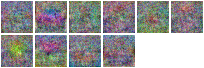

In [23]:
Ws = {}
for i = 1, 10 do
    table.insert(Ws, bestmodel.W[i]:reshape(3,32,32))
end
itorch.image(Ws)

### 11. Let us now try to train with slightly different hyperpameters and see what happens  and again vizualize the training and test errors over time. Let us also vizualize the rows of the Weight matrix.

In [24]:
besterr = 1e10

-- for plotting losses later on
epochloss_te = 0
epochloss_tr = 0
epochlosses_tr = {}
epochlosses_te = {}

-- define the model and criterion
model = Linear.new(0.0001)
criterion = CEC.new()
bestmodel = Linear.new(0)

-- run it
lr = 0.0001
lambda = 0.0
train_and_test_loop(100000, lr, lambda)

Plot = require 'itorch.Plot'
xaxis = {}
for i=1, #epochlosses_tr do
    table.insert(xaxis, i)
end

iter: 0, accuracy: 11%	


 -- best accuracy achieved: 11%	


iter: 1000, accuracy: 25%	
 -- best accuracy achieved: 25%	


iter: 2000, accuracy: 31%	
 -- best accuracy achieved: 31%	


iter: 3000, accuracy: 25%	


iter: 4000, accuracy: 26%	


iter: 5000, accuracy: 24%	


iter: 6000, accuracy: 31%	


iter: 7000, accuracy: 30%	


iter: 8000, accuracy: 31%	


iter: 9000, accuracy: 27%	


iter: 10000, accuracy: 33%	
 -- best accuracy achieved: 33%	


iter: 11000, accuracy: 27%	


iter: 12000, accuracy: 34%	
 -- best accuracy achieved: 34%	


iter: 13000, accuracy: 31%	


iter: 14000, accuracy: 32%	


iter: 15000, accuracy: 24%	


iter: 16000, accuracy: 34%	


iter: 17000, accuracy: 38%	


 -- best accuracy achieved: 38%	


iter: 18000, accuracy: 34%	


iter: 19000, accuracy: 39%	
 -- best accuracy achieved: 39%	


iter: 20000, accuracy: 36%	


iter: 21000, accuracy: 38%	


iter: 22000, accuracy: 36%	


iter: 23000, accuracy: 35%	


iter: 24000, accuracy: 35%	


iter: 25000, accuracy: 38%	


iter: 26000, accuracy: 37%	


iter: 27000, accuracy: 35%	


iter: 28000, accuracy: 32%	


iter: 29000, accuracy: 26%	


iter: 30000, accuracy: 31%	


iter: 31000, accuracy: 37%	


iter: 32000, accuracy: 34%	


iter: 33000, accuracy: 31%	


iter: 34000, accuracy: 33%	


iter: 35000, accuracy: 34%	


iter: 36000, accuracy: 38%	


iter: 37000, accuracy: 33%	


iter: 38000, accuracy: 27%	


iter: 39000, accuracy: 32%	


iter: 40000, accuracy: 39%	


iter: 41000, accuracy: 37%	


iter: 42000, accuracy: 32%	


iter: 43000, accuracy: 35%	


iter: 44000, accuracy: 37%	


iter: 45000, accuracy: 33%	


iter: 46000, accuracy: 37%	


iter: 47000, accuracy: 32%	


iter: 48000, accuracy: 40%	
 -- best accuracy achieved: 40%	


iter: 49000, accuracy: 33%	


iter: 50000, accuracy: 35%	


iter: 51000, accuracy: 39%	


iter: 52000, accuracy: 30%	


iter: 53000, accuracy: 40%	


iter: 54000, accuracy: 32%	


iter: 55000, accuracy: 41%	
 -- best accuracy achieved: 41%	


iter: 56000, accuracy: 34%	


iter: 57000, accuracy: 37%	


iter: 58000, accuracy: 30%	


iter: 59000, accuracy: 41%	


iter: 60000, accuracy: 33%	


iter: 61000, accuracy: 34%	


iter: 62000, accuracy: 36%	


iter: 63000, accuracy: 37%	


iter: 64000, accuracy: 40%	


iter: 65000, accuracy: 36%	


iter: 66000, accuracy: 38%	


iter: 67000, accuracy: 38%	


iter: 68000, accuracy: 35%	


iter: 69000, accuracy: 36%	


iter: 70000, accuracy: 38%	


iter: 71000, accuracy: 41%	


iter: 72000, accuracy: 40%	


iter: 73000, accuracy: 38%	


iter: 74000, accuracy: 37%	


iter: 75000, accuracy: 37%	


iter: 76000, accuracy: 39%	


iter: 77000, accuracy: 42%	
 -- best accuracy achieved: 42%	


iter: 78000, accuracy: 39%	


iter: 79000, accuracy: 39%	


iter: 80000, accuracy: 37%	


iter: 81000, accuracy: 39%	


iter: 82000, accuracy: 40%	


iter: 83000, accuracy: 39%	


iter: 84000, accuracy: 40%	


iter: 85000, accuracy: 39%	


iter: 86000, accuracy: 39%	


iter: 87000, accuracy: 38%	


iter: 88000, accuracy: 37%	


iter: 89000, accuracy: 40%	


iter: 90000, accuracy: 40%	


iter: 91000, accuracy: 37%	


iter: 92000, accuracy: 39%	


iter: 93000, accuracy: 38%	


iter: 94000, accuracy: 41%	


iter: 95000, accuracy: 41%	


iter: 96000, accuracy: 41%	


iter: 97000, accuracy: 38%	


iter: 98000, accuracy: 36%	


iter: 99000, accuracy: 40%	


iter: 100000, accuracy: 41%	


In [25]:
plot = Plot():line(xaxis, epochlosses_tr, 'red', 'train')
plot:line(xaxis, epochlosses_te, 'green', 'test'):legend(true):title('Train and Test Loss')
plot:draw():save('out.html')

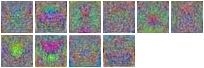

In [26]:
Ws = {}
for i = 1, 10 do
    table.insert(Ws, bestmodel.W[i]:reshape(3,32,32))
end
itorch.image(Ws)

### 12. Let us again try to train again with slightly different hyperpameters and see what happens (we add weight requlaization with lambda = 0.1). We also change the weight initiliation range back to 0.01  and again vizualize the training and test errors over time. Let us also vizualize the rows of the Weight matrix.

In [27]:
besterr = 1e10

-- for plotting losses later on
epochloss_te = 0
epochloss_tr = 0
epochlosses_tr = {}
epochlosses_te = {}

-- define the model and criterion
model = Linear.new(0.01)
criterion = CEC.new()
bestmodel = Linear.new(0)

-- run it
lr = 0.0001
lambda = 0.1
train_and_test_loop(100000, lr, lambda)

iter: 0, accuracy: 18%	
 -- best accuracy achieved: 18%	


iter: 1000, accuracy: 17%	


iter: 2000, accuracy: 26%	
 -- best accuracy achieved: 26%	


iter: 3000, accuracy: 21%	


iter: 4000, accuracy: 24%	


iter: 5000, accuracy: 27%	
 -- best accuracy achieved: 27%	


iter: 6000, accuracy: 27%	


iter: 7000, accuracy: 26%	


iter: 8000, accuracy: 27%	


iter: 9000, accuracy: 32%	
 -- best accuracy achieved: 32%	


iter: 10000, accuracy: 30%	


iter: 11000, accuracy: 34%	
 -- best accuracy achieved: 34%	


iter: 12000, accuracy: 28%	


iter: 13000, accuracy: 29%	


iter: 14000, accuracy: 31%	


iter: 15000, accuracy: 22%	


iter: 16000, accuracy: 22%	


iter: 17000, accuracy: 36%	
 -- best accuracy achieved: 36%	


iter: 18000, accuracy: 33%	


iter: 19000, accuracy: 26%	


iter: 20000, accuracy: 36%	


iter: 21000, accuracy: 35%	


iter: 22000, accuracy: 41%	
 -- best accuracy achieved: 41%	


iter: 23000, accuracy: 37%	


iter: 24000, accuracy: 31%	


iter: 25000, accuracy: 36%	


iter: 26000, accuracy: 37%	


iter: 27000, accuracy: 34%	


iter: 28000, accuracy: 28%	


iter: 29000, accuracy: 32%	


iter: 30000, accuracy: 33%	


iter: 31000, accuracy: 32%	


iter: 32000, accuracy: 36%	


iter: 33000, accuracy: 29%	


iter: 34000, accuracy: 33%	


iter: 35000, accuracy: 38%	


iter: 36000, accuracy: 40%	


iter: 37000, accuracy: 34%	


iter: 38000, accuracy: 30%	


iter: 39000, accuracy: 34%	


iter: 40000, accuracy: 37%	


iter: 41000, accuracy: 33%	


iter: 42000, accuracy: 39%	


iter: 43000, accuracy: 36%	


iter: 44000, accuracy: 35%	


iter: 45000, accuracy: 37%	


iter: 46000, accuracy: 32%	


iter: 47000, accuracy: 38%	


iter: 48000, accuracy: 38%	


iter: 49000, accuracy: 33%	


iter: 50000, accuracy: 38%	


iter: 51000, accuracy: 50%	
 -- best accuracy achieved: 50%	


iter: 52000, accuracy: 39%	


iter: 53000, accuracy: 36%	


iter: 54000, accuracy: 38%	


iter: 55000, accuracy: 37%	


iter: 56000, accuracy: 44%	


iter: 57000, accuracy: 34%	


iter: 58000, accuracy: 34%	


iter: 59000, accuracy: 35%	


iter: 60000, accuracy: 39%	


iter: 61000, accuracy: 36%	


iter: 62000, accuracy: 39%	


iter: 63000, accuracy: 40%	


iter: 64000, accuracy: 37%	


iter: 65000, accuracy: 39%	


iter: 66000, accuracy: 39%	


iter: 67000, accuracy: 37%	


iter: 68000, accuracy: 38%	


iter: 69000, accuracy: 37%	


iter: 70000, accuracy: 40%	


iter: 71000, accuracy: 40%	


iter: 72000, accuracy: 38%	


iter: 73000, accuracy: 38%	


iter: 74000, accuracy: 39%	


iter: 75000, accuracy: 41%	


iter: 76000, accuracy: 40%	


iter: 77000, accuracy: 41%	


iter: 78000, accuracy: 41%	


iter: 79000, accuracy: 39%	


iter: 80000, accuracy: 38%	


iter: 81000, accuracy: 39%	


iter: 82000, accuracy: 40%	


iter: 83000, accuracy: 39%	


iter: 84000, accuracy: 37%	


iter: 85000, accuracy: 36%	


iter: 86000, accuracy: 37%	


iter: 87000, accuracy: 38%	


iter: 88000, accuracy: 39%	


iter: 89000, accuracy: 40%	


iter: 90000, accuracy: 36%	


iter: 91000, accuracy: 40%	


iter: 92000, accuracy: 38%	


iter: 93000, accuracy: 40%	


iter: 94000, accuracy: 40%	


iter: 95000, accuracy: 39%	


iter: 96000, accuracy: 39%	


iter: 97000, accuracy: 40%	


iter: 98000, accuracy: 43%	


iter: 99000, accuracy: 42%	


iter: 100000, accuracy: 44%	


In [28]:
Plot = require 'itorch.Plot'
xaxis = {}
for i=1, #epochlosses_tr do
    table.insert(xaxis, i)
end
plot = Plot():line(xaxis, epochlosses_tr, 'red', 'train')
plot:line(xaxis, epochlosses_te, 'green', 'test'):legend(true):title('Train and Test Loss')
plot:draw():save('out.html')

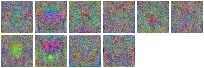

In [29]:
Ws = {}
for i = 1, 10 do
    table.insert(Ws, bestmodel.W[i]:reshape(3,32,32))
end
itorch.image(Ws)